Week Aug 2 - Aug 5

Tasks this week:
1. Go thorugh all parts of code carefully.
2. Prototypes init as mean.
3. More datasets.
4. Transformer.

In [1]:
import pandas as pd
import numpy as np
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss
from  torch.distributions import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns
import vanilla_vae

import igraph as ig
from sklearn.decomposition import TruncatedSVD
from anndata import AnnData

Dataset Loading, Label & Hierarchical encoding & Preprocessing

In [2]:
# Load dataset // No problem
# dataset = sc.read('./datasets/filtered_data_500.h5ad')
# dataset = sc.read('./datasets/filtered_data.h5ad')
dataset = sc.read("/Volumes/SSD/global.h5ad")
# Get all celltypes. // No problem
list_celltypes = dataset.obs['Manually_curated_celltype'].unique().tolist()
# These are the celltypes that we're going to remove. // No problem
list_celltypes = list(filter(lambda x: x not in ['Mast cells', 'pDC','Progenitor', 'Erythroid', 'Megakaryocytes'], list_celltypes))
# Remove the doublets // No problem
list_filtered_celltypes = list(filter(lambda x: 'doublets' not in x, list_celltypes))
# Remove celltypes from the dataset // No problem
dataset = dataset[dataset.obs['Manually_curated_celltype'].isin(list_filtered_celltypes)]

# Label encoder // No problem
encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['Manually_curated_celltype'])

# Get the list of filtered celltypes // No problem
list_ct = dataset.obs['Manually_curated_celltype'].unique().tolist()
# Transform list of filtered celltypes to list of numbers // No problem
list_num_ct = encoder_celltype.transform(list_ct)
# These are higher level celltypes // No problem
list_inner_nodes = ['Cross-tissue Immune Cell Atlas', 'B cell', 'Germinal center B cell', 'Myeloid', 'Dendritic cell',
                    'Macrophages', 'Monocytes', 'T & Innate lymphoid cells', 'CD4', 'T Naive', 'CD8', 
                    'Tissue-resident memory T (Trm) cells', 'NK']
all_nodes = list_ct + list_inner_nodes

# The label encoder for inner nodes (High level celltype) // No problem
encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

# The transform function for both inner nodes and detailed celltypes // No problem
def transfrom(x):
    if x in list_inner_nodes:
        return encoder_celltype_inner.transform([x])[0] + len(list_ct)
    else:
        return encoder_celltype.transform([x])[0]

# Initialize the hierarchical tree // No problem
g = ig.Graph()
g.add_vertices(len(all_nodes))
g.vs['name'] = np.append(encoder_celltype.inverse_transform(list(range(len(list_ct)))), encoder_celltype_inner.inverse_transform(list(range(len(list_inner_nodes)))))
g.add_edges([(transfrom('Cross-tissue Immune Cell Atlas'), transfrom('B cell')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('Myeloid')),
             (transfrom('Cross-tissue Immune Cell Atlas'), transfrom('T & Innate lymphoid cells'))])
g.add_edges([(transfrom('B cell'), transfrom('ABCs')),
             (transfrom('B cell'), transfrom('Germinal center B cell')),
             (transfrom('B cell'), transfrom('Memory B cells')),
             (transfrom('B cell'), transfrom('Naive B cells')),
             (transfrom('B cell'), transfrom('Plasma cells')),
             (transfrom('B cell'), transfrom('Plasmablasts')),
             (transfrom('B cell'), transfrom('Pre-B')),
             (transfrom('B cell'), transfrom('Pro-B'))])
g.add_edges([(transfrom('Germinal center B cell'), transfrom('GC_B (I)')),
             (transfrom('Germinal center B cell'), transfrom('GC_B (II)'))])
g.add_edges([(transfrom('Myeloid'), transfrom('Cycling')),
             (transfrom('Myeloid'), transfrom('Dendritic cell')),
             (transfrom('Myeloid'), transfrom('Macrophages')),
             (transfrom('Myeloid'), transfrom('Monocytes'))])
g.add_edges([(transfrom('Dendritic cell'), transfrom('DC1')),
             (transfrom('Dendritic cell'), transfrom('DC2')),
             (transfrom('Dendritic cell'), transfrom('migDC'))])
g.add_edges([(transfrom('Macrophages'), transfrom('Alveolar macrophages')),
             (transfrom('Macrophages'), transfrom('Erythrophagocytic macrophages')),
             (transfrom('Macrophages'), transfrom('Intermediate macrophages')),
             (transfrom('Macrophages'), transfrom('Intestinal macrophages'))])
g.add_edges([(transfrom('Monocytes'), transfrom('Classical monocytes')),
             (transfrom('Monocytes'), transfrom('Nonclassical monocytes'))])
g.add_edges([(transfrom('T & Innate lymphoid cells'), transfrom('CD4')),
             (transfrom('T & Innate lymphoid cells'), transfrom('CD8')),
             (transfrom('T & Innate lymphoid cells'), transfrom('Cycling T&NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('ILC3')),
             (transfrom('T & Innate lymphoid cells'), transfrom('NK')),
             (transfrom('T & Innate lymphoid cells'), transfrom('T_CD4/CD8'))])
g.add_edges([(transfrom('CD4'), transfrom('T Naive')),
             (transfrom('CD4'), transfrom('Teffector/EM_CD4')),
             (transfrom('CD4'), transfrom('Tfh')),
             (transfrom('CD4'), transfrom('Tregs')),
             (transfrom('CD4'), transfrom('Trm_Th1/Th17'))])
g.add_edges([(transfrom('CD8'), transfrom('MAIT')),
             (transfrom('CD8'), transfrom('Tem/emra_CD8')),
             (transfrom('CD8'), transfrom('Tgd_CRTAM+')),
             (transfrom('CD8'), transfrom('Tissue-resident memory T (Trm) cells')),
             (transfrom('CD8'), transfrom('Tnaive/CM_CD8')),
             (transfrom('CD8'), transfrom('Trm_Tgd'))])
g.add_edges([(transfrom('NK'), transfrom('NK_CD16+')),
             (transfrom('NK'), transfrom('NK_CD56bright_CD16-'))])
g.add_edges([(transfrom('T Naive'), transfrom('Tnaive/CM_CD4')),
             (transfrom('T Naive'), transfrom('Tnaive/CM_CD4_activated'))])
g.add_edges([(transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm/em_CD8')),
             (transfrom('Tissue-resident memory T (Trm) cells'), transfrom('Trm_gut_CD8')),])

# g.write('tree', format='gml')
layout = g.layout("kamada_kawai")
ig.plot(g, layout=layout, vertex_label=g.vs["name"], vertex_label_size=10, vertex_size=15, bbox=(1000, 1000), margin=100, vertex_color='white')

# return the shortest distance between two nodes // No problem
def get_shortest_dist(node_1, node_2, graph):
    return len(graph.get_shortest_paths(node_1, node_2)[0])-1
 
# Construct the distance matrix, init with 0 // No problem
dist_df = pd.DataFrame(0, index=np.arange(len(list_num_ct)), columns=np.arange(len(list_num_ct)))
for i in range(len(list_num_ct)):
    for j in range(len(list_num_ct)):
        dist_df.iloc[i, j]=get_shortest_dist(i, j, g)

# Convert to tensor // No problem
D = dist_df
D = torch.tensor(D.values, dtype=float)

# Train test split // No problem
train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset, cross_validation=False, k_fold=5)
sc.pp.normalize_total(dataset, 1e4)
sc.pp.log1p(dataset)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset[train_indices].X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.obs = dataset.obs
dataset = dataset_pca

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
encoders = {
    'obs': {
        'Manually_curated_celltype': encoder_celltype.transform
    }
}
dataloader_training = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=test_subsampler)

/opt/homebrew/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [3]:
# Pytorch version of the 3 fully connected layers
class Net(nn.Module):
    def __init__(self, mode, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.mode = mode
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PL(nn.Module):
    def __init__(self, centers):
        super(PL, self).__init__()
        self.centers = centers

    def forward(self, mapping, labels):
        targets = torch.index_select(self.centers, 0, labels)
        dist = torch.norm(mapping - targets, dim=1)
        dist = torch.sum(dist)
        return dist/mapping.shape[0]

In [4]:
def train(mode, loss_mode, epochs=30, cuda=1):
    D_metric = D.cuda()
    if mode == 'Net':
        model = Net(mode, 128, 32, 37).cuda()
    elif mode == 'Proto_Net':
        model = Net(mode, 128, 32, 16).cuda()
        model = prototypical_network.LearntPrototypes(model, n_prototypes= D.shape[0],
                prototypes=None, embedding_dim=16, device='cuda').cuda()
    elif mode == 'VAE':
        model_vae = vanilla_vae.VanillaVAE(128, 16, [64]).cuda()
        model = prototypical_network.LearntPrototypes(model_vae, n_prototypes= D.shape[0],
                prototypes=None, embedding_dim=16, device='cuda', mode=mode).cuda()
    criterion = nn.CrossEntropyLoss()
    delta = DistortionLoss(D_metric)
    opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)

        model.train()
        t0 = time.time()
        for batch in dataloader_training:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                out = model(x)
            elif mode == 'Proto_Net':
                out, embeddings = model(x)
            elif mode == 'VAE':
                out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            opt.zero_grad()
            xe_loss = criterion(out, y)
            loss = 2 * xe_loss
            if 'pl' in loss_mode:
                pl_loss = PL(centers = model.prototypes.data)
                pl_loss_ = pl_loss(embeddings, y)
                loss = loss + pl_loss_
            if 'disto' in loss_mode:
                disto_loss = delta(model.prototypes)
                loss = loss + disto_loss * 2
            if 'vae' in loss_mode:
                vae_loss = model_vae.loss_function(x_hat, x, mean, log_var, decoder_mu,decoder_log_var, M_N=1)
                loss = loss + vae_loss['loss']/20
            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
        t1 = time.time()
        
        print('Train ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        t0 = time.time()
        for batch in dataloader_testing:
            x = batch.X.cuda()
            y = batch.obs['Manually_curated_celltype'].type(torch.LongTensor).cuda()
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                with torch.no_grad():
                    out = model(x)
            elif mode == 'Proto_Net':
                with torch.no_grad():
                    out, embeddings = model(x)
            elif mode == 'VAE':
                with torch.no_grad():
                    out, embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(x)
            pred = out.detach()
            ER_meter.add(pred.cpu(),y)
        t1 = time.time()
        print('Test ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))
    return model

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(mode, model):
    y_test = dataset[test_indices].obs['Manually_curated_celltype']
    if mode == 'Net':
        y_pred = model(torch.tensor(dataset[test_indices].X).cuda())
    elif mode == 'Proto_Net':
        y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X).cuda())
    elif mode == 'VAE':
        y_pred, y_embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[test_indices].X).cuda())
    y_pred = y_pred.detach().cpu().numpy()
    pred = encoder_celltype.inverse_transform(y_pred.argmax(axis=1))
    cm=confusion_matrix(y_test, pred)
    # Normalise
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))),
                                        yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['Manually_curated_celltype'].unique().tolist()))))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show(block=False)

def plot_distance_matrix(mode, model):
    y_test = encoder_celltype.transform(dataset[test_indices].obs['Manually_curated_celltype'])
    if mode == 'Net':
        y_pred = model(torch.tensor(dataset[test_indices].X).cuda())
    elif mode == 'Proto_Net':
        y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X).cuda())
    elif mode == 'VAE':
        y_pred, y_embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[test_indices].X).cuda())
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = y_pred.argmax(axis=1)
    dist_list = []
    for i in range(len(y_pred)):
        distance = dist_df.iloc[y_pred[i], y_test[i]]
        dist_list.append(distance)
    print(np.mean(np.array(dist_list)))
    sns.displot(dist_list)
    plt.show(block=False)



Epoch 1
Train ER 25.31, time 5.2s
Test ER 18.22, time 0.4s
Epoch 2
Train ER 16.78, time 4.8s
Test ER 16.04, time 0.5s
Epoch 3
Train ER 15.49, time 5.0s
Test ER 15.13, time 0.5s
Epoch 4
Train ER 14.65, time 5.4s
Test ER 14.74, time 0.5s
Epoch 5
Train ER 14.14, time 5.6s
Test ER 14.22, time 0.4s
Epoch 6
Train ER 13.75, time 5.5s
Test ER 14.01, time 0.4s
Epoch 7
Train ER 13.49, time 5.5s
Test ER 13.64, time 0.5s
Epoch 8
Train ER 13.28, time 5.5s
Test ER 13.47, time 0.4s
Epoch 9
Train ER 13.12, time 5.6s
Test ER 13.12, time 0.5s
Epoch 10
Train ER 12.99, time 5.5s
Test ER 13.09, time 0.5s
Epoch 11
Train ER 12.92, time 5.5s
Test ER 13.06, time 0.5s
Epoch 12
Train ER 12.75, time 5.4s
Test ER 12.99, time 0.4s
Epoch 13
Train ER 12.70, time 5.8s
Test ER 12.78, time 0.4s
Epoch 14
Train ER 12.63, time 5.5s
Test ER 12.74, time 0.5s
Epoch 15
Train ER 12.57, time 5.5s
Test ER 12.76, time 0.5s
Epoch 16
Train ER 12.54, time 5.4s
Test ER 12.59, time 0.5s
Epoch 17
Train ER 12.57, time 5.5s
Test ER 12.51,

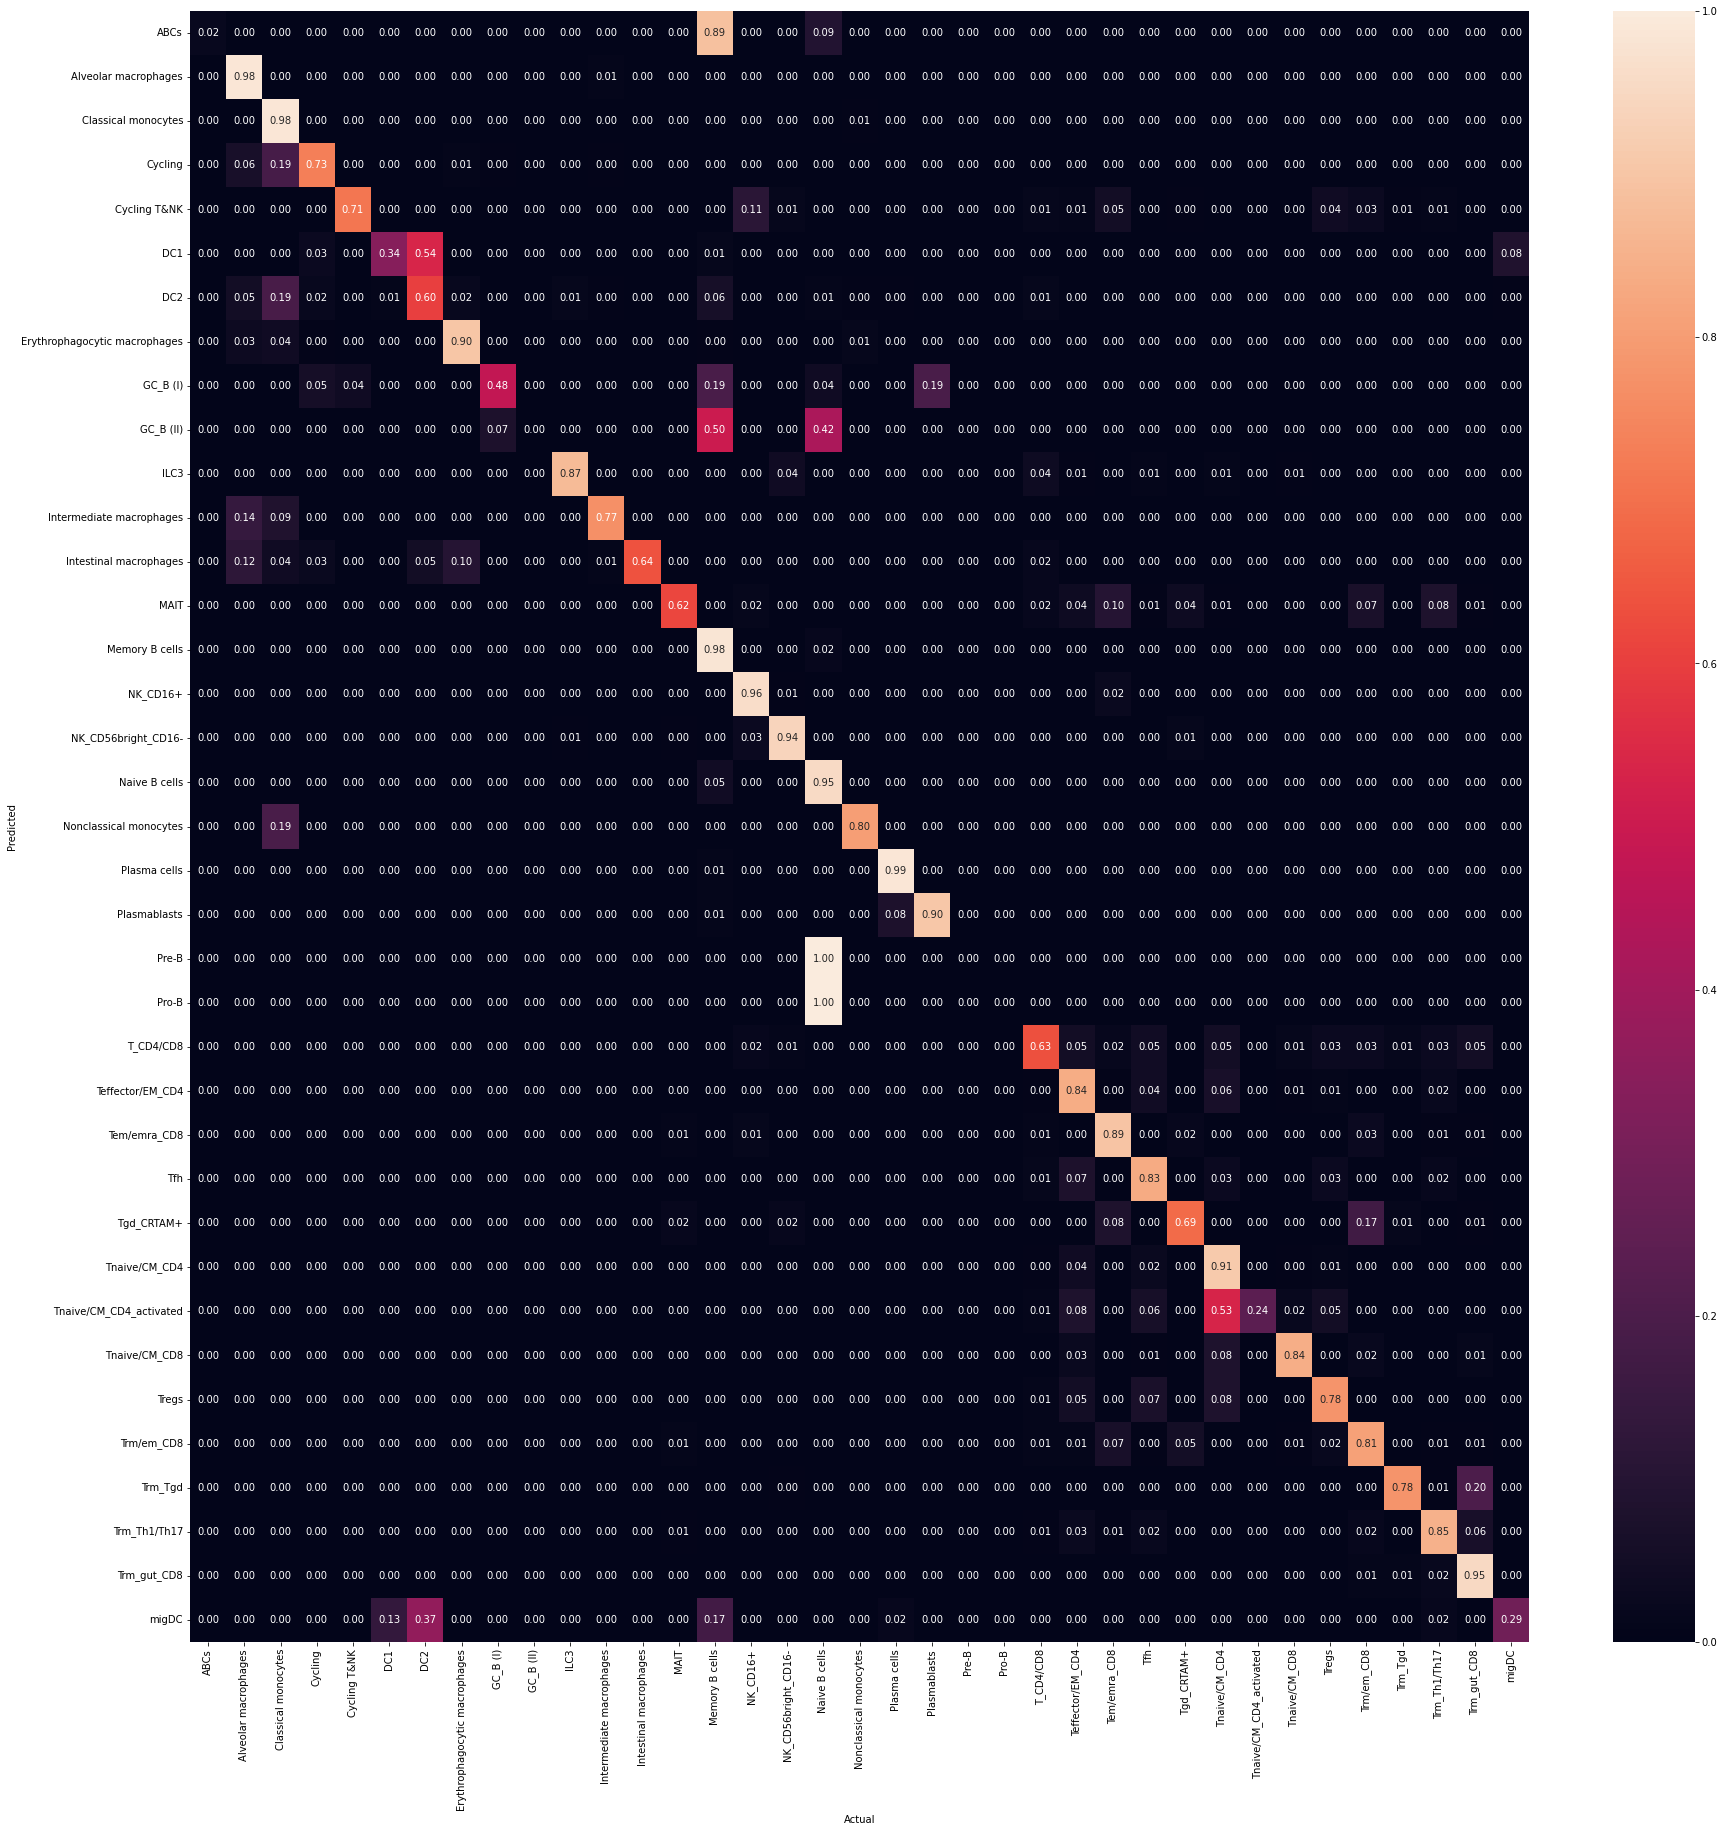

In [6]:
mode='VAE'
loss_mode='vae_disto_pl'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)

0.3566632150365559


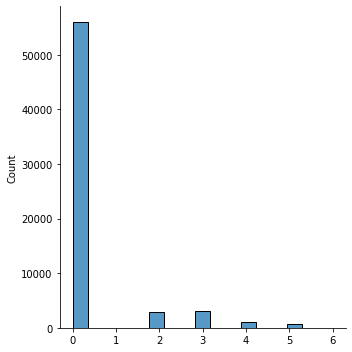

In [7]:
plot_distance_matrix(mode, model)

In [8]:
X_train = dataset[train_indices].X
X_test = dataset[test_indices].X
y_train = encoder_celltype.transform(dataset[train_indices].obs['Manually_curated_celltype'])
y_test = encoder_celltype.transform(dataset[test_indices].obs['Manually_curated_celltype'])

In [9]:
y_pred, y_embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[test_indices].X).cuda())
y_pred = y_pred.detach().cpu().numpy()
y_pred_self = encoder_celltype.inverse_transform(y_pred.argmax(axis=1))

Log Regression

c:\Users\xbh04\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.25542062819668016


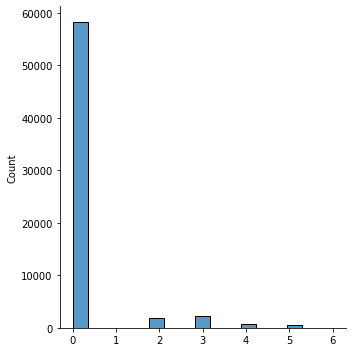

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
clf.score(X_test, y_test)
log_reg_y_pred = clf.predict(X_test)
log_dist_list = []
for i in range(len(log_reg_y_pred)):
    distance = dist_df.iloc[log_reg_y_pred[i], y_test[i]]
    log_dist_list.append(distance)
print(np.mean(np.array(log_dist_list)))
sns.displot(log_dist_list)
plt.show(block=False)

KNN

0.32233518466221095


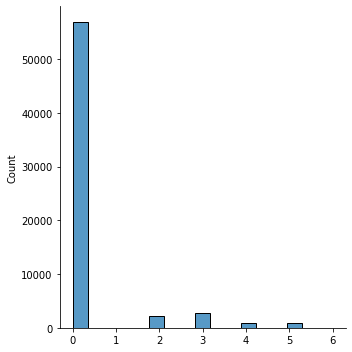

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
knn_dist_list = []
for i in range(len(knn_y_pred)):
    distance = dist_df.iloc[knn_y_pred[i], y_test[i]]
    knn_dist_list.append(distance)
print(np.mean(np.array(knn_dist_list)))
sns.displot(knn_dist_list)
plt.show(block=False)

In [12]:
lookupObj = {
    'Cross-tissue Immune Cell Atlas': list_ct,
    'B cell': ['ABCs', 'Memory B cells', 'Naive B cells', 'Plasma cells', 'Plasmablasts', 'Pre-B', 'Pro-B', 'GC_B (I)', 'GC_B (II)'],
    'Germinal center B cell': ['GC_B (I)', 'GC_B (II)'],
    
    'Myeloid': ['Cycling', 'DC1', 'DC2', 'migDC', 'Alveolar macrophages', 'Erythrophagocytic macrophages', 'Intermediate macrophages', 'Intestinal macrophages', 'Classical monocytes', 'Nonclassical monocytes'],
    'Dendritic cell': ['DC1', 'DC2', 'migDC'],
    'Macrophages': ['Alveolar macrophages', 'Erythrophagocytic macrophages', 'Intermediate macrophages', 'Intestinal macrophages'],
    'Monocytes': ['Classical monocytes', 'Nonclassical monocytes'],

    'T & Innate lymphoid cells': ['ILC3', 'Cycling T&NK', 'T_CD4/CD8', 'Teffector/EM_CD4', 'Tfh', 'Tregs', 'Trm_Th1/Th17', 'Tnaive/CM_CD4', 
                                    'Tnaive/CM_CD4_activated', 'MAIT', 'Tem/emra_CD8', 'Tgd_CRTAM+', 'Tnaive/CM_CD8', 'Trm_Tgd', 'Trm/em_CD8', 'Trm_gut_CD8', 'NK_CD16+', 'NK_CD56bright_CD16-'],
    'CD4': ['Teffector/EM_CD4', 'Tfh', 'Tregs', 'Trm_Th1/Th17', 'Tnaive/CM_CD4', 'Tnaive/CM_CD4_activated'],
    'T Naive': ['Tnaive/CM_CD4', 'Tnaive/CM_CD4_activated'],
    'CD8': ['MAIT', 'Tem/emra_CD8', 'Tgd_CRTAM+', 'Tnaive/CM_CD8', 'Trm_Tgd', 'Trm/em_CD8', 'Trm_gut_CD8'],
    'Tissue-resident memory T (Trm) cells': ['Trm/em_CD8', 'Trm_gut_CD8'],
    'NK': ['NK_CD16+', 'NK_CD56bright_CD16-']
}

In [13]:
log_reg_y_pred_str = encoder_celltype.inverse_transform(log_reg_y_pred)
knn_y_pred_str = encoder_celltype.inverse_transform(knn_y_pred)
y_test_str = encoder_celltype.inverse_transform(y_test)

In [14]:
highest_granularity_list_knn = []
highest_granularity_list_log = []
highest_granularity_list_self = []
highest_granularity_list_y_test = []
b_cells = lookupObj['B cell']
t_cells = lookupObj['T & Innate lymphoid cells']
myeloid = lookupObj['Myeloid']
for i in range(len(log_reg_y_pred_str)):
    if log_reg_y_pred_str[i] in b_cells:
        highest_granularity_list_log.append('B cell')
    elif log_reg_y_pred_str[i] in t_cells:
        highest_granularity_list_log.append('T & Innate lymphoid cells')
    elif log_reg_y_pred_str[i] in myeloid:
        highest_granularity_list_log.append('Myeloid')
    else:
        print("1st if: " + log_reg_y_pred_str[i])
    
    if knn_y_pred_str[i] in b_cells:
        highest_granularity_list_knn.append('B cell')
    elif knn_y_pred_str[i] in t_cells:
        highest_granularity_list_knn.append('T & Innate lymphoid cells')
    elif knn_y_pred_str[i] in myeloid:
        highest_granularity_list_knn.append('Myeloid')
    else:
        print("2nd if: " + knn_y_pred_str[i])

    if y_test_str[i] in b_cells:
        highest_granularity_list_y_test.append('B cell')
    elif y_test_str[i] in t_cells:
        highest_granularity_list_y_test.append('T & Innate lymphoid cells')
    elif y_test_str[i] in myeloid:
        highest_granularity_list_y_test.append('Myeloid')
    else:
        print("3rd if: " + y_test_str[i])

    if y_pred_self[i] in b_cells:
        highest_granularity_list_self.append('B cell')
    elif y_pred_self[i] in t_cells:
        highest_granularity_list_self.append('T & Innate lymphoid cells')
    elif y_pred_self[i] in myeloid:
        highest_granularity_list_self.append('Myeloid')
    else:
        print("4th if: " + y_pred_self[i])

list_bool_log = np.array(np.array(highest_granularity_list_log)!=np.array(highest_granularity_list_y_test))
list_bool_knn = np.array(np.array(highest_granularity_list_knn)!=np.array(highest_granularity_list_y_test))
list_bool_self = np.array(np.array(highest_granularity_list_self)!=np.array(highest_granularity_list_y_test))
print("Highest Granularity Accuracy")
print(("logistic regression: " + str(np.mean(list_bool_log)*100) + "%"))
print(("knn: " + str(np.mean(list_bool_knn)*100)) + "%")
print(("our model: " + str(np.mean(list_bool_self)*100)) + "%")

Highest Granularity Accuracy
logistic regression: 0.029809532774796827%
knn: 0.05491229721673099%
our model: 0.1082556716558411%


In [15]:
least_granularity_list_knn = []
least_granularity_list_log = []
least_granularity_list_self = []
least_granularity_list_y_test = []
b_cells = lookupObj['B cell']
gcb = lookupObj['Germinal center B cell']

t_cells = lookupObj['T & Innate lymphoid cells']
tnaive = lookupObj['T Naive']
cd4 = lookupObj['CD4']
cd8 = lookupObj['CD8']
trm = lookupObj['Tissue-resident memory T (Trm) cells']
nk = lookupObj['NK']

myeloid = lookupObj['Myeloid']
macrophages = lookupObj['Macrophages']
dc = lookupObj['Dendritic cell']
monocytes = lookupObj['Monocytes']
for i in range(len(log_reg_y_pred_str)):
    if log_reg_y_pred_str[i] in gcb:
        least_granularity_list_log.append('Germinal center B cell')
    elif log_reg_y_pred_str[i] in b_cells:
        least_granularity_list_log.append('B cell')
    elif log_reg_y_pred_str[i] in tnaive:
        least_granularity_list_log.append('T Naive')
    elif log_reg_y_pred_str[i] in trm:
        least_granularity_list_log.append('Tissue-resident memory T (Trm) cells')
    elif log_reg_y_pred_str[i] in nk:
        least_granularity_list_log.append('NK')
    elif log_reg_y_pred_str[i] in cd4:
        least_granularity_list_log.append('CD4')
    elif log_reg_y_pred_str[i] in cd8:
        least_granularity_list_log.append('CD8')
    elif log_reg_y_pred_str[i] in t_cells:
        least_granularity_list_log.append('T & Innate lymphoid cells')
    elif log_reg_y_pred_str[i] in macrophages:
        least_granularity_list_log.append('Macrophages')
    elif log_reg_y_pred_str[i] in dc:
        least_granularity_list_log.append('Dendritic cell')
    elif log_reg_y_pred_str[i] in monocytes:
        least_granularity_list_log.append('Monocytes')
    elif log_reg_y_pred_str[i] in myeloid:
        least_granularity_list_log.append('Myeloid')

    if knn_y_pred_str[i] in gcb:
        least_granularity_list_knn.append('Germinal center B cell')
    elif knn_y_pred_str[i] in b_cells:
        least_granularity_list_knn.append('B cell')
    elif knn_y_pred_str[i] in tnaive:
        least_granularity_list_knn.append('T Naive')
    elif knn_y_pred_str[i] in trm:
        least_granularity_list_knn.append('Tissue-resident memory T (Trm) cells')
    elif knn_y_pred_str[i] in nk:
        least_granularity_list_knn.append('NK')
    elif knn_y_pred_str[i] in cd4:
        least_granularity_list_knn.append('CD4')
    elif knn_y_pred_str[i] in cd8:
        least_granularity_list_knn.append('CD8')
    elif knn_y_pred_str[i] in t_cells:
        least_granularity_list_knn.append('T & Innate lymphoid cells')
    elif knn_y_pred_str[i] in macrophages:
        least_granularity_list_knn.append('Macrophages')
    elif knn_y_pred_str[i] in dc:
        least_granularity_list_knn.append('Dendritic cell')
    elif knn_y_pred_str[i] in monocytes:
        least_granularity_list_knn.append('Monocytes')
    elif knn_y_pred_str[i] in myeloid:
        least_granularity_list_knn.append('Myeloid')
    
    if y_test_str[i] in gcb:
        least_granularity_list_y_test.append('Germinal center B cell')
    elif y_test_str[i] in b_cells:
        least_granularity_list_y_test.append('B cell')
    elif y_test_str[i] in tnaive:
        least_granularity_list_y_test.append('T Naive')
    elif y_test_str[i] in trm:
        least_granularity_list_y_test.append('Tissue-resident memory T (Trm) cells')
    elif y_test_str[i] in nk:
        least_granularity_list_y_test.append('NK')
    elif y_test_str[i] in cd4:
        least_granularity_list_y_test.append('CD4')
    elif y_test_str[i] in cd8:
        least_granularity_list_y_test.append('CD8')
    elif y_test_str[i] in t_cells:
        least_granularity_list_y_test.append('T & Innate lymphoid cells')
    elif y_test_str[i] in macrophages:
        least_granularity_list_y_test.append('Macrophages')
    elif y_test_str[i] in dc:
        least_granularity_list_y_test.append('Dendritic cell')
    elif y_test_str[i] in monocytes:
        least_granularity_list_y_test.append('Monocytes')
    elif y_test_str[i] in myeloid:
        least_granularity_list_y_test.append('Myeloid')

    if y_pred_self[i] in gcb:
        least_granularity_list_self.append('Germinal center B cell')
    elif y_pred_self[i] in b_cells:
        least_granularity_list_self.append('B cell')
    elif y_pred_self[i] in tnaive:
        least_granularity_list_self.append('T Naive')
    elif y_pred_self[i] in trm:
        least_granularity_list_self.append('Tissue-resident memory T (Trm) cells')
    elif y_pred_self[i] in nk:
        least_granularity_list_self.append('NK')
    elif y_pred_self[i] in cd4:
        least_granularity_list_self.append('CD4')
    elif y_pred_self[i] in cd8:
        least_granularity_list_self.append('CD8')
    elif y_pred_self[i] in t_cells:
        least_granularity_list_self.append('T & Innate lymphoid cells')
    elif y_pred_self[i] in macrophages:
        least_granularity_list_self.append('Macrophages')
    elif y_pred_self[i] in dc:
        least_granularity_list_self.append('Dendritic cell')
    elif y_pred_self[i] in monocytes:
        least_granularity_list_self.append('Monocytes')
    elif y_pred_self[i] in myeloid:
        least_granularity_list_self.append('Myeloid')


list_bool_log = np.array(np.array(least_granularity_list_log)!=np.array(least_granularity_list_y_test))
list_bool_knn = np.array(np.array(least_granularity_list_knn)!=np.array(least_granularity_list_y_test))
list_bool_self = np.array(np.array(least_granularity_list_self)!=np.array(least_granularity_list_y_test))
print("Lowest Granularity Accuracy")
print(("logistic regression: " + str(np.mean(list_bool_log)*100) + "%"))
print(("knn: " + str(np.mean(list_bool_knn)*100)) + "%")
print(("our model: " + str(np.mean(list_bool_self)*100)) + "%")

Lowest Granularity Accuracy
logistic regression: 5.566538014998901%
knn: 7.058583576516364%
our model: 7.5120022592488%
